# Preprocessing and clustering 

This project was made by my colleague Mihajlo Madzarevic and me.

The idea was to preprocess data of multiple gene experessions in cells and then cluster that data using map and reduce functions from python.

First we import the data and transfer it into a format that suits our use.
Below is a 2D picture of genes in cells.

Drive already mounted at ClusteringDomaciFiles; to attempt to forcibly remount, call drive.mount("ClusteringDomaciFiles", force_remount=True).


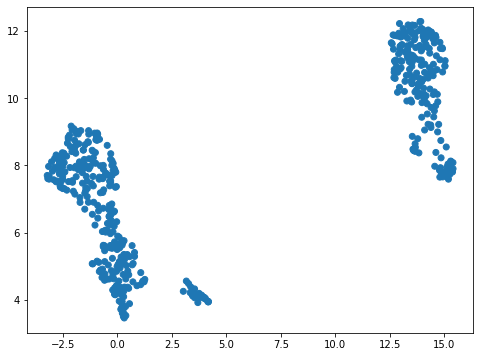

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from google.colab import drive
drive.mount("ClusteringDomaciFiles")

df = pd.read_table('ClusteringDomaciFiles/MyDrive/ClusteringDomaciFiles/ekspresije.tsv', index_col=0)
data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]

embedding = pd.read_table('ClusteringDomaciFiles/MyDrive/ClusteringDomaciFiles/umap.tsv')
embedding['cluster'] = 0
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)

We import reduce

In [ ]:
from functools import reduce

The column cluster is where we will apply our coloring after clustering the data(different groups will have different colours).

In [ ]:
print(embedding)

         cell      umap1      umap2  cluster
0      cell_0  12.815239  10.924154        0
1      cell_1  15.045142  10.946535        0
2     cell_10   0.673210   5.612355        0
3    cell_100  -0.131373   5.724038        0
4    cell_101  -1.572635   8.453780        0
..        ...        ...        ...      ...
529   cell_95   3.981964   4.074621        0
530   cell_96  -0.486648   4.613284        0
531   cell_97  12.974499  11.449237        0
532   cell_98  -0.313820   8.180772        0
533   cell_99  15.040093  10.957005        0

[534 rows x 4 columns]


And these are some gene measurements for different cells.

In [ ]:
print(df.head())

          cell_0  cell_1  cell_2  cell_3  cell_4  cell_5  cell_6  cell_7  \
NOC2L        0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
HES4         0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
ISG15        0.0     1.0     0.0     5.0     1.0     0.0     0.0     1.0   
TNFRSF18     2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
TNFRSF4      0.0     0.0     0.0     0.0     0.0    12.0     0.0     0.0   

          cell_8  cell_9  ...  cell_524  cell_525  cell_526  cell_527  \
NOC2L        0.0     0.0  ...       0.0       1.0       0.0       1.0   
HES4         0.0     2.0  ...       0.0       0.0       0.0       2.0   
ISG15        2.0     4.0  ...       1.0       2.0       0.0       3.0   
TNFRSF18     0.0     0.0  ...       0.0       0.0       0.0       0.0   
TNFRSF4      0.0     0.0  ...       0.0       0.0       0.0       0.0   

          cell_528  cell_529  cell_530  cell_531  cell_532  cell_533  
NOC2L          0.0       0.0     

# 1. Normalization inside of cells

Average of cell genes

In [ ]:
#1.1
data_sorted = data

num_of_genes = df.shape[0]

def cell_gene_avg(array, x):
  global num_of_genes
  if array and array[-1][0] == x[0]:
    array[-1] = array[-1][0], array[-1][1] + x[2]
  else:
    if array:
      array[-1] = array[-1][0], array[-1][1] / num_of_genes
    array = array + [(x[0], x[2])]
  return array

data_cell_gene_avg = reduce(cell_gene_avg, data_sorted, [])

#dividing the last element
data_cell_gene_avg[-1] = (data_cell_gene_avg[-1][0], data_cell_gene_avg[-1][1] / num_of_genes)

for i in range(0,10):
  print(data_cell_gene_avg[i])

('cell_0', 0.9208760852407262)
('cell_1', 0.596093133385951)
('cell_2', 0.7399368587213891)
('cell_3', 0.574388318863457)
('cell_4', 0.8733228097868981)
('cell_5', 0.5507103393843725)
('cell_6', 0.9319258089976322)
('cell_7', 0.6124704025256511)
('cell_8', 1.058208366219416)
('cell_9', 0.7801894238358327)


Cell gene values being centered (gene_value - average_gene_value)

In [ ]:
#1.2
gene_index = 0

def center(entry):
  global gene_index
  cell, gene, val = entry
  while cell != data_cell_gene_avg[gene_index][0]:
    gene_index += 1
  return (cell, gene, val-data_cell_gene_avg[gene_index][1])

data_cells_centered = map(center, data)

data_cells_centered_lista = list(data_cells_centered)

for i in range(0,10):
  print(data_cells_centered_lista[i])

('cell_0', 'NOC2L', -0.9208760852407262)
('cell_0', 'HES4', -0.9208760852407262)
('cell_0', 'ISG15', -0.9208760852407262)
('cell_0', 'TNFRSF18', 1.0791239147592737)
('cell_0', 'TNFRSF4', -0.9208760852407262)
('cell_0', 'SDF4', -0.9208760852407262)
('cell_0', 'UBE2J2', -0.9208760852407262)
('cell_0', 'CPSF3L', -0.9208760852407262)
('cell_0', 'AURKAIP1', 0.07912391475927383)
('cell_0', 'CCNL2', -0.9208760852407262)


Calculating the variance of each cell

In [ ]:
#1.3
def cell_variance(array, x):
  global num_of_genes
  if array and array[-1][0] == x[0]:
    array[-1] = array[-1][0], array[-1][1] + (x[2]*x[2])
  else:
    if array:
      array[-1] = array[-1][0], array[-1][1] / num_of_genes
    array = array + [(x[0], x[2]*x[2])]
  return array

data_cell_variance = reduce(cell_variance, data_cells_centered_lista, [])

#dividing the last element
data_cell_variance[-1] = (data_cell_variance[-1][1], data_cell_variance[-1][1] / num_of_genes)

for i in range(0,10):
  print(data_cell_variance[i])

('cell_0', 27.060235065151407)
('cell_1', 14.772731382013905)
('cell_2', 16.018791787648073)
('cell_3', 9.980851539815506)
('cell_4', 19.29571295262077)
('cell_5', 9.89581046621491)
('cell_6', 24.917425888735902)
('cell_7', 11.502149145730824)
('cell_8', 32.859082188628506)
('cell_9', 17.090594123549497)


Calculating the standard deviation of cells (square root of variance)

In [ ]:
#1.4
from math import sqrt

def standard_deviation(entry):
  cell, val = entry
  return (cell, sqrt(val))

data_cell_standard_deviation = map(standard_deviation, data_cell_variance);

data_cell_standard_deviation_list = list(data_cell_standard_deviation)

for i in range(0,10):
  print(data_cell_standard_deviation_list[i])

('cell_0', 5.20194531547107)
('cell_1', 3.8435311085008674)
('cell_2', 4.002348284151203)
('cell_3', 3.1592485720208066)
('cell_4', 4.392688579061891)
('cell_5', 3.1457607134387877)
('cell_6', 4.9917357591058344)
('cell_7', 3.3914818510100897)
('cell_8', 5.73228420340692)
('cell_9', 4.134077179196042)


Standardization of the cells ((x-x_avg)/standard_deviation_x)

In [ ]:
#1.5
gene_index = 0

def standardization(entry):
  global data_cell_gene_avg
  global data_cell_standard_deviation_list
  global gene_index

  cell, gene, val = entry
  while cell != data_cell_gene_avg[gene_index][0]:
    gene_index += 1 
  return (cell, gene, (val - data_cell_gene_avg[gene_index][1])/data_cell_standard_deviation_list[gene_index][1])

data_cell_standardization = map(standardization, data_cells_centered_lista);

data_cell_standardization_list = list(data_cell_standardization)

for i in range(0,10):
  print(data_cell_standardization_list[i])

('cell_0', 'NOC2L', -0.35405065966455085)
('cell_0', 'HES4', -0.35405065966455085)
('cell_0', 'ISG15', -0.35405065966455085)
('cell_0', 'TNFRSF18', 0.030420894477284056)
('cell_0', 'TNFRSF4', -0.35405065966455085)
('cell_0', 'SDF4', -0.35405065966455085)
('cell_0', 'UBE2J2', -0.35405065966455085)
('cell_0', 'CPSF3L', -0.35405065966455085)
('cell_0', 'AURKAIP1', -0.16181488259363339)
('cell_0', 'CCNL2', -0.35405065966455085)


#2. Normalization inside of cells

Calculating avg expression of genes, centering expressions of genes and calculating variance for genes

In [ ]:
#2.1
num_of_cells = df.shape[1]

genes_sorted = sorted(data_cell_standardization_list, key=lambda x: x[1])

def gene_avg(array, x):
  global num_of_cells
  if array and array[-1][0] == x[1]:
    array[-1] = array[-1][0], array[-1][1] + x[2]
  else:
    if array:
      array[-1] = array[-1][0], array[-1][1] / num_of_cells
    array = array + [(x[1], x[2])]
  return array

data_gene_avg = reduce(gene_avg, genes_sorted, [])

#dividing the last element
data_gene_avg[-1] = data_gene_avg[-1][0], data_gene_avg[-1][1] / num_of_cells

indx = 0

def gene_center(entry):
  global indx
  global data_gene_avg
  cell, gene, val = entry
  while gene != data_gene_avg[indx][0]:
    indx += 1
  return (gene, val - data_gene_avg[indx][1])

data_gene_center = map(gene_center, genes_sorted)

data_gene_center_list = list(data_gene_center)

def gene_variance(array, x):
  global num_of_cells
  if array and array[-1][0] == x[0]:
    array[-1] = array[-1][0], array[-1][1] + (x[1]*x[1])
  else:
    if array:
      array[-1] = array[-1][0], array[-1][1] / num_of_cells
    array = array + [(x[0], x[1]*x[1])]
  return array

data_gene_variance = reduce(gene_variance, data_gene_center_list, [])

#dividing the last element
data_gene_variance[-1] = data_gene_variance[-1][0], data_gene_variance[-1][1] / num_of_cells

for i in range(0,10):
  print(data_gene_variance[i])

('A1BG', 0.010777298425614146)
('AAAS', 0.007881568823216091)
('AAED1', 0.009315159649612794)
('AAGAB', 0.005950906647345742)
('AAK1', 0.01453823384234865)
('AAMP', 0.015229461224729731)
('AASDHPPT', 0.007484003211683521)
('AATF', 0.06932300772521335)
('ABCE1', 0.007008447021508967)
('ABCF1', 0.011145874154079501)


These are the names of 500 most variable genes in cells.

In [ ]:
#2.2 & #2.6
most_variable = sorted(data_gene_variance, key=lambda x: x[1], reverse=True)

def most_500_variable(array, x):
  if  array:
    if len(array) < 500:
      array = array + [x[0]]
  else:
    array = array + [x[0]]
  return array
  
data_most_500_variable = reduce(most_500_variable, most_variable, [])

for i in range(0,10):
  print(data_most_500_variable[i])

FTL
FTH1
LYZ
MALAT1
B2M
TMSB4X
S100A9
ACTB
CD74
RPL13


In [ ]:
#2.3
sort1 = sorted(data_most_500_variable)
sort2 = sorted(data_cell_standardization_list, key=lambda x: x[1], reverse=False)

indx = 0

def filter_gene(array, x):
  global sort1
  global indx
  global num_of_cells
  if (indx >= len(sort1)):
    return array
  if len(array) % num_of_cells != 0:
    array = array + [x]
  elif x[1] == sort1[indx]:
    array = array + [x]
    indx += 1
    print(indx)
  return array

data_filter_gene = reduce(filter_gene, sort2, [])

for i in range(0,10):
  print(data_filter_gene[i])

s1 ABI3 s2 ('cell_0', 'A1BG', -0.35405065966455085)
s1 ABRACL s2 ('cell_1', 'A1BG', -0.05000252667315148)
s1 ABT1 s2 ('cell_2', 'A1BG', -0.3697513590466109)
s1 ACADVL s2 ('cell_3', 'A1BG', -0.3636233780085565)
s1 ACAP1 s2 ('cell_4', 'A1BG', -0.39762564273263656)
s1 ACTB s2 ('cell_5', 'A1BG', -0.35012856320044994)
s1 ACTG1 s2 ('cell_6', 'A1BG', -0.3733874764094353)
s1 ADSL s2 ('cell_7', 'A1BG', -0.36118158930630173)
s1 AHNAK s2 ('cell_8', 'A1BG', -0.36921001425242717)
s1 AIF1 s2 ('cell_9', 'A1BG', -0.37744308585334974)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146


Sorting the entries by alphabetically by genom and value measured for that gene(descending).

In [ ]:
#2.4
data_filter_gene_sorted = sorted(data_filter_gene, key=lambda x: (x[1],-x[2]), reverse=False)

for i in range(0,10):
  print(data_filter_gene_sorted[i])

('cell_516', 'ABI3', 9.171830784110298)
('cell_8', 'ABI3', 2.7708994711254786)
('cell_157', 'ABI3', 1.9343898073250025)
('cell_487', 'ABI3', 1.1752432466772613)
('cell_67', 'ABI3', 0.8736904509004484)
('cell_120', 'ABI3', 0.8097513004936081)
('cell_101', 'ABI3', 0.7687947270180652)
('cell_134', 'ABI3', 0.7562816930572844)
('cell_482', 'ABI3', 0.6990076875081633)
('cell_135', 'ABI3', 0.6459738441827961)


Providing a rank for the previously sorted list of entries(tuples).

In [ ]:
#2.5
def gene_rank(array, x):
  if array:
    if array[-1][2] == x[2]:
      array = array + [(x[0],x[1],x[2],array[-1][3])]
    else:
      array = array + [(x[0],x[1],x[2],array[-1][3]+1)]
  else:
    array = array + [(x[0],x[1],x[2],1)]
  return array

data_gene_rank = reduce(gene_rank, data_filter_gene_sorted, [])

for i in range(0,10):
  print(data_gene_rank[i])

('cell_516', 'ABI3', 9.171830784110298, 1)
('cell_8', 'ABI3', 2.7708994711254786, 2)
('cell_157', 'ABI3', 1.9343898073250025, 3)
('cell_487', 'ABI3', 1.1752432466772613, 4)
('cell_67', 'ABI3', 0.8736904509004484, 5)
('cell_120', 'ABI3', 0.8097513004936081, 6)
('cell_101', 'ABI3', 0.7687947270180652, 7)
('cell_134', 'ABI3', 0.7562816930572844, 8)
('cell_482', 'ABI3', 0.6990076875081633, 9)
('cell_135', 'ABI3', 0.6459738441827961, 10)


# 3. K-means clustering

This is the #2.5 list sorted by cells, the array after the cell name are the expressions of genes.

In [ ]:
#3.1
from itertools import groupby

data_gene_rank_sorted = sorted(data_gene_rank, key=lambda x: (x[0],x[1]))

#print("{0} {1} {2} {3}".format(data_gene_rank_sorted[0][0], data_gene_rank_sorted[0][1], data_gene_rank_sorted[500][0], data_gene_rank_sorted[500][1]))

def groupby_reduce(array, x):
  if array:
    if array[-1][0] == x[0]:
      array[-1] = (array[-1][0], array[-1][1] + [x[2]])
    else:
      array = array + [(x[0], [x[2]])]
  else:
    array = array + [(x[0], [x[2]])]
  return array

data_gene_rank_grouped = reduce(groupby_reduce, data_gene_rank_sorted, [])

for i in range(0,10):
  print(data_gene_rank_grouped[i])

('cell_0', [-0.35405065966455085, -0.35405065966455085, -0.35405065966455085, -0.35405065966455085, 0.22265667154820148, 5.028551098321139, 0.22265667154820148, -0.35405065966455085, -0.35405065966455085, -0.16181488259363339, 0.030420894477284056, -0.35405065966455085, 0.41489244861911895, -0.35405065966455085, -0.35405065966455085, 0.030420894477284056, -0.35405065966455085, -0.35405065966455085, -0.16181488259363339, 0.6071282256900364, -0.35405065966455085, 0.41489244861911895, 0.41489244861911895, 1.3760713339737063, -0.16181488259363339, -0.16181488259363339, -0.16181488259363339, -0.16181488259363339, 0.030420894477284056, -0.35405065966455085, -0.16181488259363339, 0.030420894477284056, 0.030420894477284056, 0.030420894477284056, 14.06363262065426, -0.16181488259363339, -0.16181488259363339, 0.7993640027609539, 0.22265667154820148, -0.35405065966455085, -0.16181488259363339, -0.16181488259363339, -0.35405065966455085, -0.35405065966455085, 0.22265667154820148, -0.16181488259363

And here starts the clustering.
First we make a list of centroids and a function that will generate k centroids based on the k parameter passed.


We draw the 2D picture of genes like before and also the clusters so we see their position.

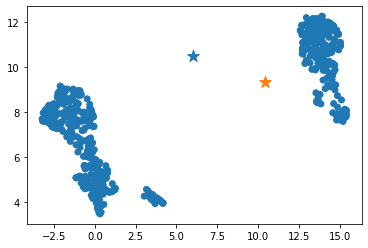

In [ ]:
#3.2
import numpy as np
import matplotlib.pyplot as plt

centroids = []

def reset_clusters(k):
  global centroids
  np.random.seed(20)
  centroids = np.random.uniform(-2.5, 12, (k, 2))

reset_clusters(2)

# Da pogledamo rezultat
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)
for c in centroids:
  plt.scatter(*c, marker='*', s=150)

Here we make a 2D matrix of X and Y cordinates for the genes on the 2D picture because previously we had to deal with them through tuples and this is faster for calculation purposes.

In [ ]:
array_from_umap = np.column_stack((embedding.umap1,embedding.umap2))

And then the whole clustering is provided here, the picture outcomes are for (2,4,5,10) clusters and for each of those (1,10,250) iterations.

***One note*** the colours of genes are coloured and then the clusters are moved so the pictures might look a bit odd. Think of it like the colours are from the ith iteration and clusters from i+1th iteration.

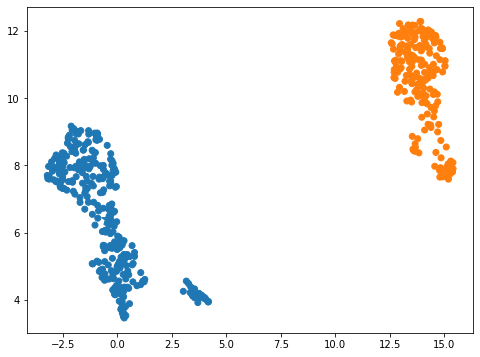

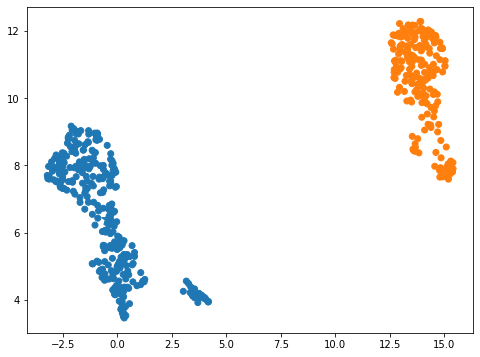

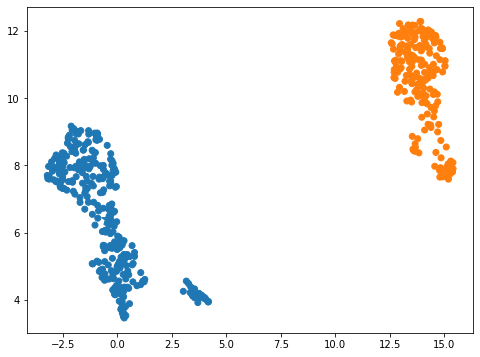

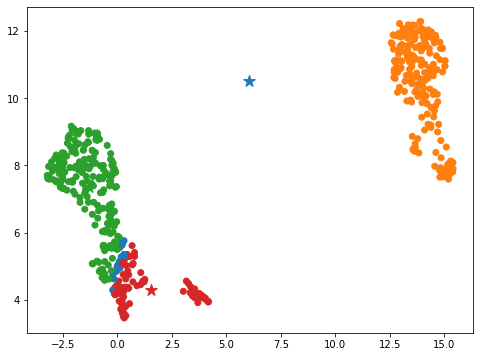

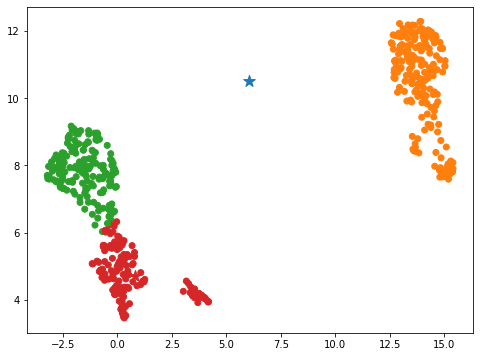

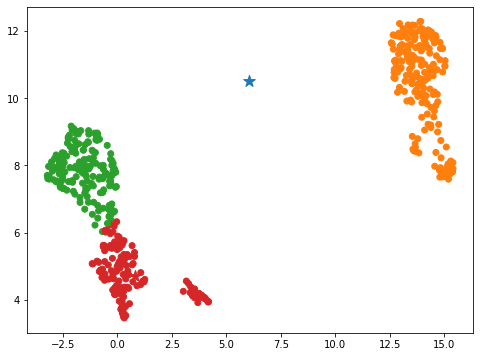

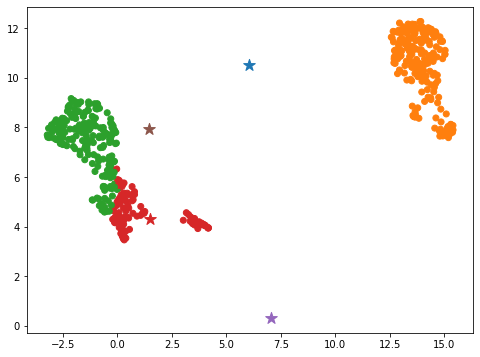

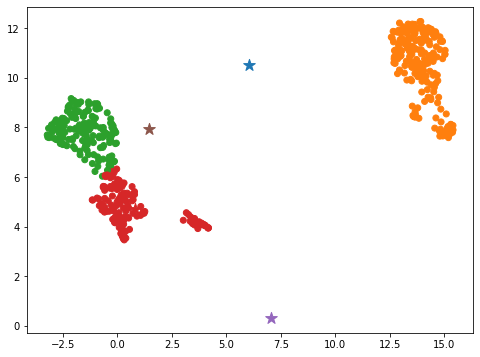

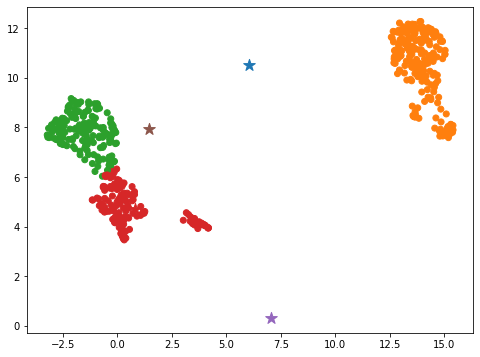

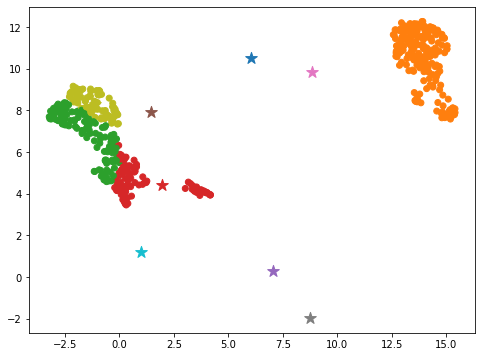

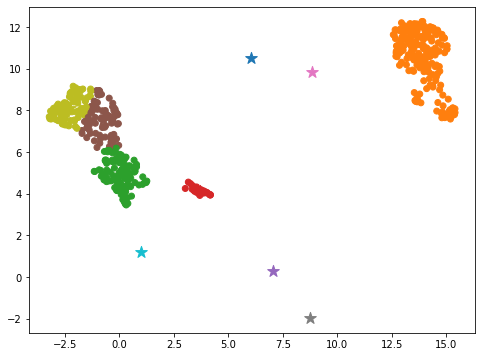

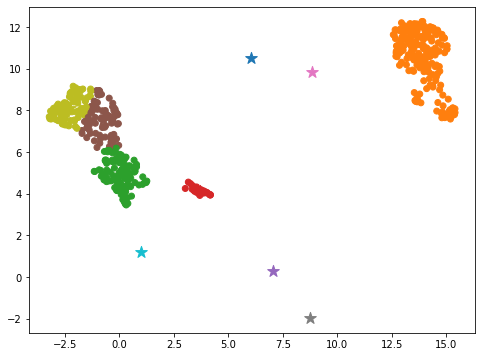

In [ ]:
from math import sqrt

curr_centroid = 0
curr_cell = 0

def closest_cluster(entry):
  global centroids
  global curr_centroid
  global curr_cell
  min_val = 3000000
  min_indx = -1
  for i in range(0,len(centroids)):
    temp = sqrt((entry[0]-centroids[i][0])**2 + (entry[1]-centroids[i][1])**2)
    #if i == 0:
      #print("entry0 {0} centroid0 {1} entry1 {2} centroid1 {3} res {4}".format(entry[0], centroids[i][0], entry[1], centroids[i][1], temp))
    if temp < min_val:
      min_val = temp
      min_indx = i
  curr_cell += 1
  if curr_centroid == min_indx:
    #print(curr_cell)
    #print("{0} {1} {2} {3}".format(entry[0], entry[1], embedding.loc[curr_cell, 'umap1'], embedding.loc[curr_cell, 'umap2']))
    embedding.loc[curr_cell,'cluster'] = curr_centroid
    return [entry[0], entry[1]]
  return [0, 0]

def pos_sum(tup, x):
  if x[0] != 0 and x[1] != 0:
    return (tup[0] + x[0], tup[1] + x[1], tup[2] + 1)
  return (tup[0], tup[1], tup[2])

for g in (2,4,6,10):
  reset_clusters(g)
  for l in (1,10,250):
    for j in range(0,l):
      for i in range(0,len(centroids)):
        curr_centroid = i
        curr_cell = -1
        temp = map(closest_cluster, array_from_umap)
        temp = list(temp)
        cluster_new_pos = reduce(pos_sum, temp, (0,0,0))
        if (cluster_new_pos[2] != 0):
          centroids[i] = [ cluster_new_pos[0]/cluster_new_pos[2], cluster_new_pos[1]/cluster_new_pos[2]]
    #print res
    plt.figure(figsize=(8, 6))
    plt.scatter(
        embedding.umap1,
        embedding.umap2,
        c=[sn.color_palette()[int(x)] for x in embedding.cluster]
    )
    for c in centroids:
      plt.scatter(*c, marker='*', s=150)

This part of the code was here for testing purposes.

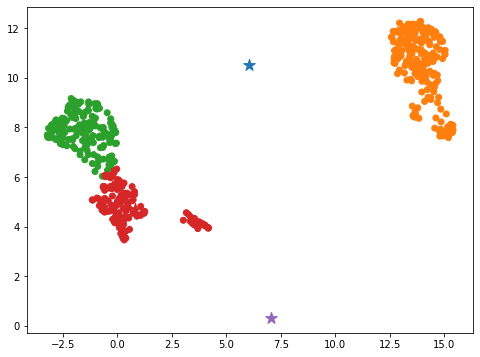

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[int(x)] for x in embedding.cluster]
)
for c in centroids:
  plt.scatter(*c, marker='*', s=150)